In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.weightstats import ttest_ind

In [61]:
def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values

    if scaler == True:
        scaler = StandardScaler()

    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.iloc[indices]
    return matched

In [5]:
df = pd.read_csv('ecls.csv')

In [6]:
df.shape

(11078, 22)

In [7]:
df.columns

Index(['childid', 'catholic', 'race', 'race_white', 'race_black',
       'race_hispanic', 'race_asian', 'p5numpla', 'p5hmage', 'p5hdage',
       'w3daded', 'w3momed', 'w3daded_hsb', 'w3momed_hsb', 'w3momscr',
       'w3dadscr', 'w3inccat', 'w3income', 'w3povrty', 'p5fstamp', 'c5r2mtsc',
       'c5r2mtsc_std'],
      dtype='object')

In [8]:
df['w3income_1k'] = df['w3income']/1000

In [9]:
summary = df.groupby(['catholic']).agg(['count', 'mean', 'std'])['c5r2mtsc_std']
summary

,count,mean,std
catholic,,,
0,9568,-0.030596,1.015856
1,1510,0.193868,0.868602


Student's t-test assumes that the sample means (test statistics) of two population distributions being compared are normally distributed with equal variance. Welch's t-test is designed for unequal sample distribution variance, but the assumption of sample distribution normality is maintained.

In [10]:
#STUDENT T-TEST
cath = df[df['catholic']==1]
pub = df[df['catholic']==0]

ttest, p_value, degree_of_freedom = ttest_ind(pub['c5r2mtsc_std'], cath['c5r2mtsc_std'])

print('Student t-test %f \np_value %f \nStudent t-test Degrees of Freedom %s'  %(ttest, p_value, degree_of_freedom))
print('-------------------------------------------------------------------------------------')
print('Not a suitable test here as counts in public and catholic schools are not balanced')


Student t-test -8.129942 
p_value 0.000000 
Student t-test Degrees of Freedom 11076.0
-------------------------------------------------------------------------------------
Not a suitable test here as counts in public and catholic schools are not balanced


In [11]:
# WELCH T_TEST

def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(pub['c5r2mtsc_std'], cath['c5r2mtsc_std'])


 Welch's t-test= -9.1069 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2214.5139


# Difference-in-means: pre-treatment covariates

In [12]:
covs=['race_white', 'p5hmage', 'w3income', 'p5numpla', 'w3momed_hsb']
covs_means = df.groupby(['catholic']).agg(['mean'])[['race_white', 'p5hmage', 'w3income', 'p5numpla', 'w3momed_hsb']]
covs_means    

,race_white,p5hmage,w3income,p5numpla,w3momed_hsb
,mean,mean,mean,mean,mean
catholic,,,,,
0,0.556125,37.560970,54889.159064,1.132669,0.464092
1,0.725166,39.575163,82074.300501,1.092701,0.227207


In [13]:
for cov in covs:
   
    welch_ttest(pub[cov].dropna(), cath[cov].dropna())


 Welch's t-test= -13.4534 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2143.2902

 Welch's t-test= -12.6650 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2186.9123

 Welch's t-test= -20.2499 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1825.0966

 Welch's t-test= 4.2458 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2233.6894

 Welch's t-test= 18.8553 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2107.3301


# Propensity score estimation

In [14]:
df1=df[['catholic', 'race_white' , 'w3income' , 'p5hmage' , 'p5numpla' , 'w3momed_hsb','w3income_1k']]

df1 = df1.dropna(subset = ['catholic', 'race_white' , 'w3income_1k' , 'p5hmage' , 'p5numpla' , 'w3momed_hsb'])

df1

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k
0,0,1,62500.5,47.0,1.0,0.0,62.5005
1,0,1,45000.5,41.0,1.0,0.0,45.0005
3,0,1,62500.5,43.0,1.0,0.0,62.5005
4,1,1,87500.5,38.0,1.0,0.0,87.5005
5,0,1,150000.5,47.0,1.0,0.0,150.0005
...,...,...,...,...,...,...,...
11070,0,1,87500.5,39.0,1.0,0.0,87.5005
11072,0,0,62500.5,30.0,1.0,1.0,62.5005
11073,0,1,22500.5,32.0,1.0,0.0,22.5005
11074,0,0,22500.5,31.0,1.0,1.0,22.5005


In [15]:
x1=df1[['race_white' , 'w3income_1k' , 'p5hmage' , 'p5numpla' , 'w3momed_hsb']]

x1 = sm.add_constant(x1, prepend = False)
y1=df1['catholic']


mdl = sm.Logit(y1, x1)
mdl_fit=mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.386794
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               catholic   No. Observations:                 9267
Model:                          Logit   Df Residuals:                     9261
Method:                           MLE   Df Model:                            5
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                 0.06913
Time:                        21:51:29   Log-Likelihood:                -3584.4
converged:                       True   LL-Null:                       -3850.6
Covariance Type:            nonrobust   LLR p-value:                8.053e-113
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
race_white      0.3145      0.070      4.487      0.000       0.177       0.452
w3income_1k     0.0073    

In [16]:
propensity_score=mdl_fit.predict(x1)

In [17]:
propensity_score

0        0.229293
1        0.180136
3        0.209296
4        0.215402
5        0.360493
           ...   
11070    0.220381
11072    0.061973
11073    0.125350
11074    0.048337
11077    0.191437
Length: 9267, dtype: float64

In [18]:
df1['propensity_score']=propensity_score
df1

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k,propensity_score
0,0,1,62500.5,47.0,1.0,0.0,62.5005,0.229293
1,0,1,45000.5,41.0,1.0,0.0,45.0005,0.180136
3,0,1,62500.5,43.0,1.0,0.0,62.5005,0.209296
4,1,1,87500.5,38.0,1.0,0.0,87.5005,0.215402
5,0,1,150000.5,47.0,1.0,0.0,150.0005,0.360493
...,...,...,...,...,...,...,...,...
11070,0,1,87500.5,39.0,1.0,0.0,87.5005,0.220381
11072,0,0,62500.5,30.0,1.0,1.0,62.5005,0.061973
11073,0,1,22500.5,32.0,1.0,0.0,22.5005,0.125350
11074,0,0,22500.5,31.0,1.0,1.0,22.5005,0.048337


# Examining the region of common support

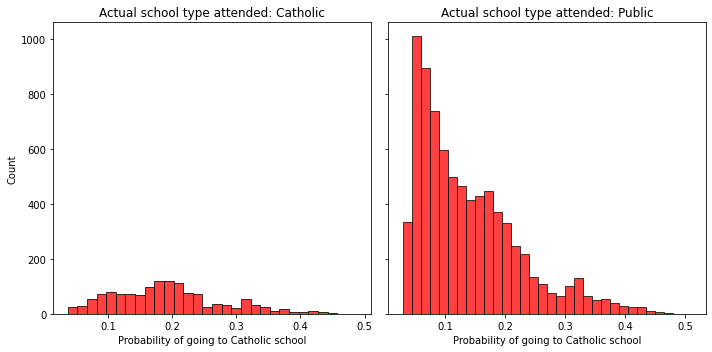

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

df_cath=df1[df1['catholic']==1]
df_pub=df1[df1['catholic']==0]

sns.histplot(df_cath['propensity_score'] , color="r", ax=axes[0], binwidth=0.015).set_title('Actual school type attended: Catholic')
sns.histplot(df_pub['propensity_score'] , color="r", ax=axes[1], binwidth=0.015).set_title('Actual school type attended: Public')
axes[0].set(xlabel='Probability of going to Catholic school')
axes[1].set(xlabel='Probability of going to Catholic school')


#plt.xlabel("Common X-Axis")
plt.tight_layout();


# Executing a matching algorithm

In [20]:
df_cath

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k,propensity_score
4,1,1,87500.5,38.0,1.0,0.0,87.5005,0.215402
39,1,1,62500.5,39.0,2.0,0.0,62.5005,0.169386
40,1,1,150000.5,41.0,2.0,0.0,150.0005,0.290602
41,1,1,87500.5,35.0,1.0,0.0,87.5005,0.200958
42,1,1,150000.5,41.0,1.0,0.0,150.0005,0.321143
...,...,...,...,...,...,...,...,...
10231,1,1,45000.5,47.0,1.0,0.0,45.0005,0.207489
10232,1,1,62500.5,43.0,2.0,0.0,62.5005,0.186470
10233,1,0,45000.5,42.0,1.0,0.0,45.0005,0.141765
10235,1,0,150000.5,41.0,1.0,0.0,150.0005,0.256731


In [21]:
# USING KNN AS ABOVE (finding the matching values)
matched_df = get_matching_pairs(df_cath,df_pub)
matched_df

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k,propensity_score
1088,0,1,87500.5,38.0,1.0,0.0,87.5005,0.215402
2412,0,1,62500.5,39.0,2.0,0.0,62.5005,0.169386
7965,0,1,150000.5,41.0,2.0,0.0,150.0005,0.290602
377,0,1,87500.5,35.0,1.0,0.0,87.5005,0.200958
747,0,1,150000.5,41.0,1.0,0.0,150.0005,0.321143
...,...,...,...,...,...,...,...,...
2786,0,1,45000.5,47.0,1.0,0.0,45.0005,0.207489
10561,0,1,62500.5,43.0,2.0,0.0,62.5005,0.186470
819,0,0,45000.5,42.0,1.0,0.0,45.0005,0.141765
6221,0,0,150000.5,41.0,1.0,0.0,150.0005,0.256731


In [22]:
matched_df.index # get the index of matched pairs
pub_matched=df_pub.loc[matched_df.index] #filter the data in pub with indexes that are matched with cath
pub_matched 

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k,propensity_score
1088,0,1,87500.5,38.0,1.0,0.0,87.5005,0.215402
2412,0,1,62500.5,39.0,2.0,0.0,62.5005,0.169386
7965,0,1,150000.5,41.0,2.0,0.0,150.0005,0.290602
377,0,1,87500.5,35.0,1.0,0.0,87.5005,0.200958
747,0,1,150000.5,41.0,1.0,0.0,150.0005,0.321143
...,...,...,...,...,...,...,...,...
2786,0,1,45000.5,47.0,1.0,0.0,45.0005,0.207489
10561,0,1,62500.5,43.0,2.0,0.0,62.5005,0.186470
819,0,0,45000.5,42.0,1.0,0.0,45.0005,0.141765
6221,0,0,150000.5,41.0,1.0,0.0,150.0005,0.256731


In [23]:
# Concatenating the two matched datasets
df2 = pd.concat([df_cath, pub_matched])
# .reset_index(drop=False)



#df2.index # get the index of matched pairs
matched_pairs_cath_all_columns=df.loc[df_cath.index] #filter the data in pub with indexes that are matched with cath
matched_pairs_pub_all_columns=df.loc[pub_matched.index]
matched_pairs_cath_all_columns

,childid,catholic,race,race_white,race_black,race_hispanic,race_asian,p5numpla,p5hmage,p5hdage,...,w3momed_hsb,w3momscr,w3dadscr,w3inccat,w3income,w3povrty,p5fstamp,c5r2mtsc,c5r2mtsc_std,w3income_1k
4,0001011C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,38.0,39.0,...,0.0,53.50,53.50,"$75,001 TO $100,000",87500.5,0.0,0.0,64.604,1.451278,87.5005
39,0007002C,1,"WHITE, NON-HISPANIC",1,0,0,0,2.0,39.0,NaN,...,0.0,53.50,NaN,"$50,001 TO $75,000",62500.5,0.0,0.0,52.035,0.157383,62.5005
40,0007004C,1,"WHITE, NON-HISPANIC",1,0,0,0,2.0,41.0,45.0,...,0.0,57.83,35.78,"$100,001 TO $200,000",150000.5,0.0,0.0,64.935,1.485352,150.0005
41,0007006C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,35.0,37.0,...,0.0,53.50,63.43,"$75,001 TO $100,000",87500.5,0.0,0.0,45.630,-0.501969,87.5005
42,0007008C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,41.0,40.0,...,0.0,NaN,53.50,"$100,001 TO $200,000",150000.5,0.0,0.0,48.521,-0.204360,150.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,2134016C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,47.0,49.0,...,0.0,29.60,34.95,"$40,001 TO $50,000",45000.5,0.0,0.0,48.037,-0.254185,45.0005
10232,2134019C,1,"WHITE, NON-HISPANIC",1,0,0,0,2.0,43.0,NaN,...,0.0,59.00,NaN,"$50,001 TO $75,000",62500.5,0.0,0.0,53.514,0.309636,62.5005
10233,2134020C,1,"HISPANIC, RACE SPECIFIED",0,0,1,0,1.0,42.0,50.0,...,0.0,NaN,39.20,"$40,001 TO $50,000",45000.5,0.0,0.0,46.936,-0.367525,45.0005
10235,2134022C,1,"HISPANIC, RACE SPECIFIED",0,0,1,0,1.0,41.0,51.0,...,0.0,63.43,63.43,"$100,001 TO $200,000",150000.5,0.0,0.0,66.861,1.683621,150.0005


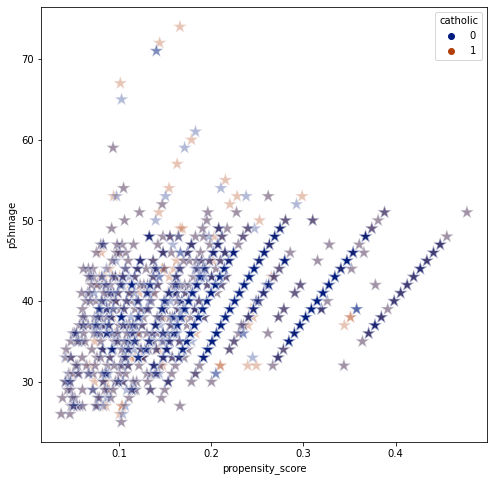

In [24]:
#Some plotting to see the matched data
fig, ax = plt.subplots(figsize=(8,8))
sns.set_palette(sns.color_palette("dark"))

sns.scatterplot(data=df2, x='propensity_score', y='p5hmage', hue='catholic' ,alpha=0.3 , marker='*', s=200);

# Difference-in-means: after matched pairs found

In [25]:
# covs=['race_white', 'p5hmage', 'w3income', 'p5numpla', 'w3momed_hsb']
covs_means = df2.groupby(['catholic']).agg(['mean'])[['race_white', 'p5hmage', 'w3income', 'p5numpla', 'w3momed_hsb']]
covs_means  

,race_white,p5hmage,w3income,p5numpla,w3momed_hsb
,mean,mean,mean,mean,mean
catholic,,,,,
0,0.741124,39.574704,82519.009246,1.091716,0.223373
1,0.741124,39.593195,82568.935651,1.091716,0.223373


In [26]:
for cov in covs:
   
    welch_ttest(pub_matched[cov].dropna(), df_cath[cov].dropna())


 Welch's t-test= 0.0000 
 p-value = 1.0000 
 Welch-Satterthwaite Degrees of Freedom= 2702.0000

 Welch's t-test= -0.0922 
 p-value = 0.9265 
 Welch-Satterthwaite Degrees of Freedom= 2701.8498

 Welch's t-test= -0.0277 
 p-value = 0.9779 
 Welch-Satterthwaite Degrees of Freedom= 2701.9958

 Welch's t-test= 0.0000 
 p-value = 1.0000 
 Welch-Satterthwaite Degrees of Freedom= 2702.0000

 Welch's t-test= 0.0000 
 p-value = 1.0000 
 Welch-Satterthwaite Degrees of Freedom= 2702.0000


##### The difference in means in two groups is not significant meaning that propensity score matching worked very well.

# Estimating treatment effects

In [27]:
df2

,catholic,race_white,w3income,p5hmage,p5numpla,w3momed_hsb,w3income_1k,propensity_score
4,1,1,87500.5,38.0,1.0,0.0,87.5005,0.215402
39,1,1,62500.5,39.0,2.0,0.0,62.5005,0.169386
40,1,1,150000.5,41.0,2.0,0.0,150.0005,0.290602
41,1,1,87500.5,35.0,1.0,0.0,87.5005,0.200958
42,1,1,150000.5,41.0,1.0,0.0,150.0005,0.321143
...,...,...,...,...,...,...,...,...
2786,0,1,45000.5,47.0,1.0,0.0,45.0005,0.207489
10561,0,1,62500.5,43.0,2.0,0.0,62.5005,0.186470
819,0,0,45000.5,42.0,1.0,0.0,45.0005,0.141765
6221,0,0,150000.5,41.0,1.0,0.0,150.0005,0.256731


In [28]:
welch_ttest(matched_pairs_cath_all_columns['c5r2mtsc_std'], matched_pairs_pub_all_columns['c5r2mtsc_std'])


 Welch's t-test= -5.0407 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2671.9305


# References:
https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html

United States Department of Education. National Center for Education Statistics. Early Childhood Longitudinal Study [United States]: Kindergarten Class of 1998-1999, Third Grade. Inter-university Consortium for Political and Social Research [distributor], 2013-08-12. https://doi.org/10.3886/ICPSR04075.v1